## Poisson Equation - 1D - Physics Informed Neural Network

Equation:
$$\frac{\partial^2 \phi}{\partial^2 x} = - f(x), \quad x \in (0, 1)$$
$$ \phi(0) = 0, \quad \phi(1) = 1 $$
$$ f(x) = \begin{cases}
      20, & 0.2 < x < 0.5 \\
      0, & \text{otherwise}
    \end{cases}\, $$

In [1]:
# import required libraries

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from Poisson1DClass import Poisson1D

Import Finite Difference Solution as pandas dataframe (feather)

In [2]:
# Extract Finite Difference Solution
import pandas as pd
FDM = pd.read_feather('FDM.feather')

Initialize PINN Hyper-parameters

In [3]:
# Reproducibility
key = jr.PRNGKey(39)

Problem Setup

In [4]:
# Create collocation points and source function
key, sampling_key = jr.split(key)

N = 101     # Number of collocation points - including boundary points
# X = jnp.linspace(0.0, 1.0, N)       # Position of the collocation points - Input to PINN (should not include boundary points for pde residual calculation)
X = jr.uniform(sampling_key, (N, ), minval=0.0 + 0.001, maxval=1.0 - 0.001)

# Source function
SourceFunction = lambda x: jnp.where((x > 0.2) & (x < 0.5), 20, 0.0)

# Boundary Condition
BC = jnp.zeros(2);
BC = BC.at[0].set(0.0);    # Left Boundary Condition
BC = BC.at[1].set(1.0);    # Right Boundary Condition

Text(0.5, 0, 'x')

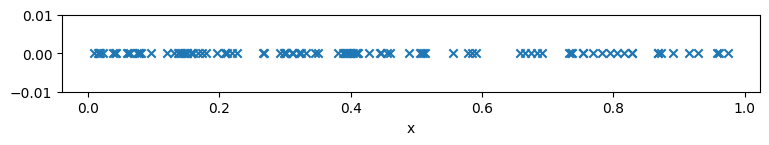

In [5]:
# position of collocation points
fig, ax = plt.subplots(figsize=(9, 1.0))

# Contour plot
plot = ax.scatter(X, jnp.zeros_like(X), marker='x')
ax.set_ylim(-0.01, 0.01)
ax.set_xlabel('x')
# ax.set_title('Randomly distributed collocation points')

Build Multilayer Perceptron (MLP) Network

In [6]:
# Our PINN is a coordinate network in the form of a MLP, mapping from scalar to scalar values
key, init_key = jr.split(key)
pinn = Poisson1D(init_key, 10, 4, SourceFunction)
pinn(0.2)

Array(-0.0198141, dtype=float32)

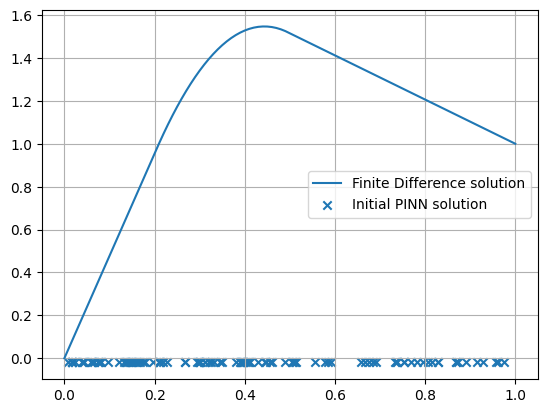

In [7]:
# plt.scatter(X, SourceFunction(X), label="Forcing Function")
plt.plot(FDM['x'], FDM['T'], label="Finite Difference solution")
plt.scatter(X, jax.vmap(pinn)(X), label="Initial PINN solution", marker='x')
plt.legend()
plt.grid()

In [8]:
def lossFunction(network, x, BC):
    # Loss from PDE
    pdeLoss = jax.vmap(network.PDE)(x)
    pdeLossRMS = jnp.mean(jnp.square(pdeLoss))
    
    # Loss from BC
    bcLossRMS = 0.5*jnp.mean(jnp.square(network(0) - BC[0])) + 0.5*jnp.mean(jnp.square(network(1)- BC[1]))

    # Totol loss
    totalLoss = pdeLossRMS + 10*bcLossRMS
    return totalLoss

pinn.PDE(0.0)
loss_history = []

In [23]:
# Training PINN
LEARNING_RATE = 1e-6
N_OPTIMIZATION_EPOCHS = 30000

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(lossFunction)(network, X, BC)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 0.0004959800862707198
Epoch: 1000, loss: 0.0004955471958965063
Epoch: 2000, loss: 0.0004953438183292747
Epoch: 3000, loss: 0.000495035492349416
Epoch: 4000, loss: 0.0004946961416862905
Epoch: 5000, loss: 0.0004945778637193143
Epoch: 6000, loss: 0.0004943625535815954
Epoch: 7000, loss: 0.0004940274520777166
Epoch: 8000, loss: 0.0004937266348861158
Epoch: 9000, loss: 0.0004935335018672049
Epoch: 10000, loss: 0.0004932506708428264
Epoch: 11000, loss: 0.0004930270952172577
Epoch: 12000, loss: 0.0004926747642457485
Epoch: 13000, loss: 0.0004924055538140237
Epoch: 14000, loss: 0.0004922752850688994
Epoch: 15000, loss: 0.0004918696358799934
Epoch: 16000, loss: 0.0004917969345115125
Epoch: 17000, loss: 0.0004915559547953308
Epoch: 18000, loss: 0.0004910956486128271
Epoch: 19000, loss: 0.0004909415729343891
Epoch: 20000, loss: 0.0004906683461740613
Epoch: 21000, loss: 0.0004904496599920094
Epoch: 22000, loss: 0.000490075908601284
Epoch: 23000, loss: 0.0004897982580587268
Epoch: 

Text(0.5, 0, 'Epochs')

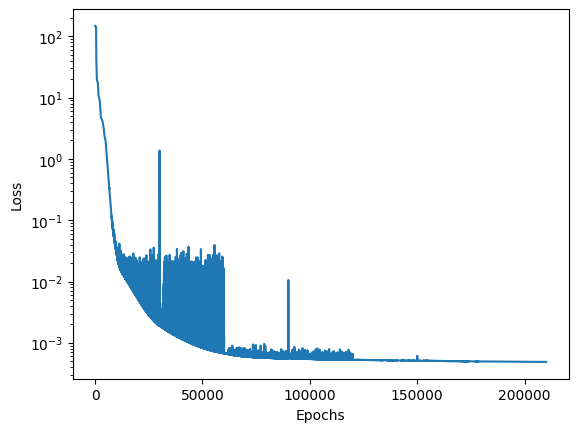

In [24]:
plt.plot(loss_history)
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [ ]:
pinn(0.5)

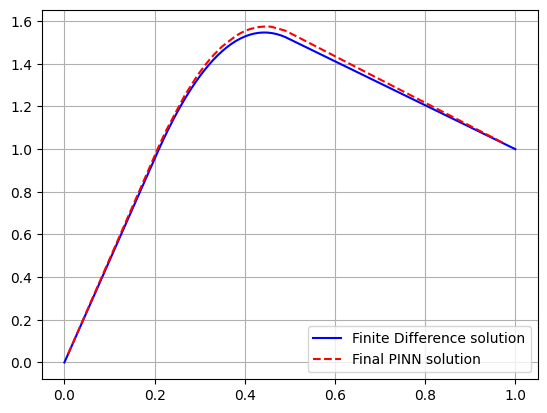

In [25]:
plt.plot(FDM['x'], FDM['T'], label="Finite Difference solution", color='blue')
# Xuniform = jnp.linspace(0.0, 1.0, 100)
# plt.plot(Xuniform, jax.vmap(pinn)(Xuniform), label="Final PINN solution", linestyle='--', color='red')
XnonUniform  = jnp.sort(jr.uniform(sampling_key, (N, ), minval=0.0, maxval=1.0))
plt.plot(XnonUniform, jax.vmap(pinn)(XnonUniform), label="Final PINN solution", linestyle='--', color='red')
plt.legend()
plt.grid()